In [1]:
import math
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
import time

np.random.seed(1)

def scale_sample(par_r, par_z, par_a):
    
    [r_min, r_max, z_min, z_max] = par_a
        
    # Scale the variables to the sampling area
    dist_r = r_max - r_min
    dist_z = z_max - z_min

    r = (dist_r * par_r) + r_min
    z = (dist_z * par_z) + z_min
        
    return r, z

def total_area(par_a):
    '''
    define the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    
    return (r_max - r_min) * (z_max - z_min)

def total_samplecount(par_a,par_d):
    '''
    define the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    r_len = (r_max - r_min)/par_d
    z_len = (z_max - z_min)/par_d
    return  r_len* z_len




def mandelbrot_area(par_mandel,par_sizecount,par_area):
    '''
    define the sampling area
    '''
    if par_sizecount == 0:
        return 0
    if par_mandel.ndim < 1:
        return par_mandel
    elif  par_mandel.ndim == 1:
        mandel_in_area = sum(1-par_mandel)
    elif  par_mandel.ndim == 2:
        mandel_in_area = sum(sum(1-par_mandel)) 
    elif  par_mandel.ndim == 3:
        mandel_in_area = sum(sum(sum(1-par_mandel)))
    elif  par_mandel.ndim >3:
        print("too many dimensions!")
        return 0
    ret_area = (mandel_in_area/par_sizecount) * par_area
    return  ret_area


def grid(par_a, par_d):
    '''
    define grid for the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    
    r_axis = np.arange(r_min, r_max + par_d, par_d)
    z_axis = np.arange(z_min, z_max + par_d, par_d)
    
    zz, rr = np.meshgrid(z_axis, r_axis)
    
    return zz, rr

def mandel(par_x,par_c):
    '''
    next step in mandelbrot iteration
    '''
    [x_r,x_z] = par_x
    [c_r,c_z] = par_c
    
    return [x_r**2 - x_z**2 + c_r, 2 * x_r * x_z + c_z]


def mandel_cond(par_x):
    '''
    define the breaking condition
    '''
    [x_r,x_z] = par_x
    
    magn = (x_r**2 + x_z**2)**0.5
    if magn > 2:
        return 1
    
    return 0
    
           
           
def mandel_i(par_c,par_i):
    '''
    define the iteration loop breaking after i iterations
    '''
    x = [0, 0]
    for _ in range(par_i):
        x = mandel(x, par_c)
        
        cond = mandel_cond(x)
        if cond:
            return 1
    
    return 0
    
    
def mandel_a(par_a, par_i, par_d):
    '''
    define the iteration loop for a square of size a with spacing d
    '''
    [r_min, r_max, z_min, z_max] = par_a
    r_axis = np.arange(r_min, r_max + par_d, par_d)
    z_axis = np.arange(z_min, z_max + par_d, par_d)
    
    plane = np.zeros((len(r_axis), len(z_axis)))
    
    for r in range(len(r_axis)):
        for z in range(len(z_axis)):
            c = [r_axis[r], z_axis[z]]
            
            result = mandel_i(c, par_i)
            plane[r, z] = result
    
    return plane   


def subspacing(par_a,par_subspaces):
    
    ret_subareas = np.zeros(np.append(par_subspaces,4))
    [r_min, r_max, z_min, z_max] = par_a
    loc_subarea = np.zeros((par_subspaces[0],4))
    if par_subspaces[0]%2 ==0:
        r_span = (r_max - r_min) /(par_subspaces[0]/2)
        z_span = (z_max - z_min) /2
    elif (r_max - r_min)<(z_max - z_min):
        r_span = (r_max - r_min)
        z_span = (z_max - z_min) /(par_subspaces[0])
    else:
        r_span = (r_max - r_min) /(par_subspaces[0])
        z_span = (z_max - z_min)

    for i in range(par_subspaces[0]):
        
        if par_subspaces[0]%2 ==0:
            loc_r_i = math.floor(i/2)
            loc_z_i = i%2
        elif (r_max - r_min)<(z_max - z_min):
            loc_r_i = 0
            loc_z_i = i
        else:
            loc_r_i = i
            loc_z_i = 0
            
        loc_subarea[i] =  [r_min+ r_span*loc_r_i,r_min+ r_span*(loc_r_i+1) ,z_min+ z_span*loc_z_i,z_min+ z_span*(loc_z_i+1) ]
        
        if len(par_subspaces) == 1:
            
            ret_subareas[i] = loc_subarea[i]
        else:
            ret_subareas[i] = subspacing(loc_subarea[i],par_subspaces[1:])
    return ret_subareas
    
    
def func_i(par_samples,par_a,par_i):
    '''
    Define function consdering the amount of maximal iterations 
    returning its specific area
    '''
    
    loc_tot_area = total_area(par_a)
    loc_sizecount = len(par_samples)
    loc_mandel = np.zeros(loc_sizecount)
    for loc_j in range(loc_sizecount):
        loc_mandel[loc_j] =  mandel_i(par_samples[loc_j], par_i)
        
    ret_area = mandelbrot_area(loc_mandel,loc_sizecount,loc_tot_area)
    return ret_area
    



    
def func_j_i(par_samples,par_a,par_i):
    '''
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_i) # instantiate the bar
    display(f)
    ret_area = []
    for loc_j in range(par_i):
        f.value +=1
        ret_area.append(func_i(par_samples,par_a,loc_j))
    return ret_area


def func_s_log_uni(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    pure random sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        loc_samples = np.empty((sample_size,2))
        
        #######
        #create sample array(start)
        ######
        for loc_sub_s in range(sample_size):
            
            loc_r = (par_a[1]-par_a[0]) * np.random.rand() + par_a[0]
            loc_z = (par_a[3]-par_a[2]) * np.random.rand() + par_a[2]
            
            loc_samples[loc_sub_s] = [loc_r,loc_z]
        
        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)

def random_permutation(array):
    # Set index k equal to the final element in the array
    k = len(array) - 1
    
    while k > 1:
        element = array[k]
        # Generate random index to swap with index k
        index = int(k * np.random.uniform()) + 1
        array[k] = array[index]
        array[index] = element
        
        k -= 1
    
    return array

def latin_hypercube_sampling_1d(par_s):
    '''
    function that returns s sampling points each in an interval [j/s, (j+1)s] with j = 0, 1, ..., s-1
    '''

    samples = np.zeros(par_s)
    for s in range(par_s):
        samples[s] = (s + np.random.uniform()) / n
        
    return samples
    
def latin_hypercube_sampling_2d(par_s):
    '''
    function that returns a latin hypercube of sampling points in 2 dimensions
    '''
    
    # Array to store the sampling points
    samples = np.zeros((par_s, 2))
    
    x = random_permutation(latin_hypercube_sampling_1d(par_s))
    y = random_permutation(latin_hypercube_sampling_1d(par_s))
    
    # Combine the x and y coordinate to form a sampling point
    for s in range(par_s):
        index_x = 0
        index_y = 0
        # Sampling points are not allowed to be on the same row or column
        if math.trunc(y[index_y] * par_s) == math.trunc(x[index_y] * par_s):
            # Generate a random index to swap with
            index_y = int((len(y) - 1) * np.random.uniform())
            if index_y == 0:
                index_y += 1
        
        # Add sampling point to the array
        samples[s, 0] = x[index_x]
        samples[s, 1] = y[index_y]
        
        # Delete the used coordinates, so they cannot be used in the swap anymore
        x = np.delete(x, index_x)
        y = np.delete(y, index_y)

    return samples

def func_s_log_latin(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    latin hypercube sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        
        #######
        #create sample array(start)
        ######
        
        loc_samples = latin_hypercube_sampling_2d(loc_s)

        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)


def ortho_sampling(par_subspacing,par_sample_size):
    ret_samples = np.empty((0,2))
    loc_subspace_dim = np.shape(par_subspacing)
    #get the amount of samples per subspace 
    loc_samples_per_subspace = par_sample_size/loc_subspace_dim[0]
    loc_samples_collected = 0
    for loc_sub_s in range(loc_subspace_dim[0]):
        loc_sample_for_subspace = max([0,math.ceil((loc_samples_per_subspace * (loc_sub_s+1))-loc_samples_collected )])
        if len(loc_subspace_dim) ==2:
            for j in range(loc_sample_for_subspace):
                loc_r = (par_subspacing[loc_sub_s][1]-par_subspacing[loc_sub_s][0]) * np.random.rand() + par_subspacing[loc_sub_s][0]
                loc_z = (par_subspacing[loc_sub_s][3]-par_subspacing[loc_sub_s][2]) * np.random.rand() + par_subspacing[loc_sub_s][2]
                #ret_samples[loc_samples_collected+ loc_sub_s] = [loc_r,loc_z]
                ret_samples = np.append(ret_samples,[[loc_r,loc_z]],axis=0)
        else:
            ret_samples = np.append(ret_samples,ortho_sampling(par_subspacing[loc_sub_s],loc_sample_for_subspace),axis=0)
        loc_samples_collected += loc_sample_for_subspace
    return ret_samples


def func_s_log_ortho(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    pure random sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        loc_samples = np.empty((sample_size,2))
        
        #######
        #create sample array(start)
        ######
        subspace_dim = [4,4]
        loc_subspacing = subspacing(par_a,subspace_dim)
        loc_samples = ortho_sampling(loc_subspacing,sample_size)
        
        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)




def func_s_d_latin(par_a,par_i,par_s, par_method):
    '''
    latin square sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_i+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    mandelbrot_a = []
    
    if par_method == 'latin_hypercube':
        # Create s samples (in [0, 1)
        sampler = qmc.LatinHypercube(d=2)
        samples = sampler.random(par_s)
    
    for loc_j in range(par_i + 1):
        f.value +=1
        
        # Counter for the number of samples in the mandelbrot area
        inside = 0
        
        for s in range(par_s):

            if par_method == 'uniform':
                # Random uniform variables
                r = np.random.uniform()
                z = np.random.uniform()

            elif par_method == 'latin_hypercube':
                # Pick from the next sample in the list
                r = samples[s][0]
                z = samples[s][1]

            # Scale the variables to the sampling area
            r, z = scale_sample(r, z, par_a)
            
            if mandel_i([r, z], loc_j) == 0:
                inside += 1
        
        mandelbrot_a.append((inside/par_s) * loc_tot_area)

    return mandelbrot_a




In [2]:
mandel([0,0.1],[0.0,0.1])

[-0.010000000000000002, 0.1]

In [25]:
area = [-2, 1, -1, 1]     # Edges of the area
spacing = 0.01            # Distance between 2 point on the grid

In [8]:
mandel_plane = mandel_a(area, 1000, spacing)

In [33]:
zz, rr = grid(area, spacing)

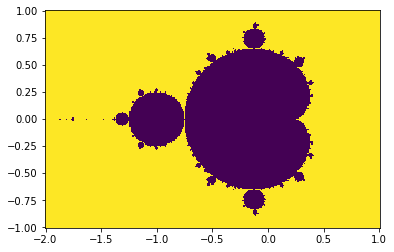

In [34]:
fig = plt.figure()
ax = plt.gca()

pc = ax.pcolormesh(rr, zz, mandel_plane)
plt.show()

In [32]:
area_estimate = func_j_i(area, 1000, 1000, 'uniform')

IntProgress(value=0, max=1001)

In [33]:
area_estimate[-1]

1.422

In [10]:
loc_sizecount = total_samplecount(area,spacing)
mandelbrot_area(mandel_plane,loc_sizecount,total_area(area))

1.5081000000000002

In [163]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 500
Samples = 15
np.random.seed(1337)
area_estimate_uni_s = func_s_log_uni(area,Iterations,Samples,par_i_range=False,par_s_range=True)

IntProgress(value=0, max=16)

KeyboardInterrupt: 

In [ ]:

plt.semilogy(area_estimate_uni_s,'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after with 2^n universal samples",size=20)
plt.xlabel('2^n universal-samples',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [ ]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 50
Samples = 10
np.random.seed(1337)
area_estimate_uni_i = func_s_log_uni(area,Iterations,Samples,par_i_range=True,par_s_range=False)

In [ ]:

plt.semilogy(area_estimate_uni_i[0],'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after i Iterations universal sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [164]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 500
Samples = 15
np.random.seed(1337)
area_estimate_ortho_s = func_s_log_ortho(area,Iterations,Samples,par_i_range=False,par_s_range=True)

IntProgress(value=0, max=16)

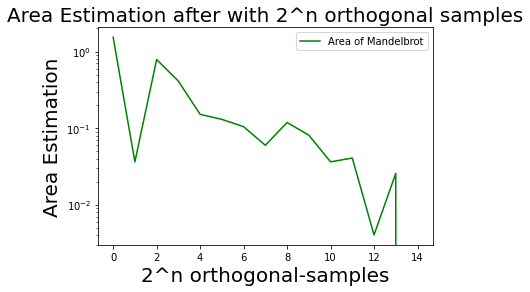

In [165]:

plt.semilogy(area_estimate_ortho_s,'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after with 2^n orthogonal samples",size=20)
plt.xlabel('2^n orthogonal-samples',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [166]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 50
Samples = 10
np.random.seed(1337)
area_estimate_ortho_i = func_s_log_ortho(area,Iterations,Samples,par_i_range=True,par_s_range=False)

IntProgress(value=0, max=11)

IntProgress(value=0, max=50)

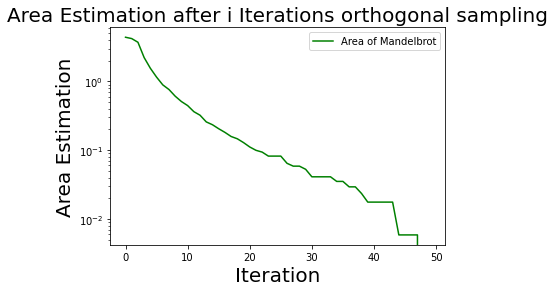

In [167]:

plt.semilogy(area_estimate_ortho_i[0],'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after i Iterations orthogonal sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()